In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FEATURES_PATH = "/content/drive/MyDrive/PkSLMNM/swin_features.npy"
LABELS_PATH = "/content/drive/MyDrive/PkSLMNM/labels.npy"




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np

# 🎯 Redefine SignLanguageDataset
class SignLanguageDataset(torch.utils.data.Dataset):
    def __init__(self, feature_file, label_file):
        self.features = np.load(feature_file)
        self.labels = np.load(label_file)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# ✅ Define paths
FEATURES_PATH = "/content/drive/MyDrive/PkSLMNM/swin_features.npy"
LABELS_PATH = "/content/drive/MyDrive/PkSLMNM/labels.npy"

# 🔥 Load dataset
dataset = SignLanguageDataset(FEATURES_PATH, LABELS_PATH)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
import torchvision.transforms as transforms

class SignLanguageDataset(torch.utils.data.Dataset):
    def __init__(self, feature_file, label_file, augment=False):
        self.features = np.load(feature_file)
        self.labels = np.load(label_file)
        self.augment = augment

        self.augment_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.augment and torch.rand(1).item() > 0.5:
            feature = self.augment_transforms(feature)

        return feature, label


In [ ]:
train_dataset = SignLanguageDataset(FEATURES_PATH, LABELS_PATH, augment=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)


In [ ]:
import torch.nn as nn

# 📌 Define SignFormer again
class SignFormer(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=512, num_classes=8):
        super(SignFormer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=8),
            num_layers=6
        )
        self.decoder = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x.mean(dim=1))
        return x

# 🚀 Reload trained model (if saved)
model_path = "/content/drive/MyDrive/PkSLMNM/signformer_checkpoint.pth"
signformer = SignFormer().to("cuda" if torch.cuda.is_available() else "cpu")
signformer.load_state_dict(torch.load(model_path))
signformer.train()  # Set to training mode


<ipython-input-5-d8767546a4ff>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  signformer.load_state_dict(torch.load(model_path))


SignFormer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=768, out_features=8, bias=True)
)

In [ ]:
import torch

# 🚀 Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# 🔥 Training loop with improvements
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(signformer.parameters(), lr=5e-5)  # Lowered LR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # Learning rate decay
num_epochs = 35  # Increased epochs for better convergence

# Increase batch size
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

for epoch in range(num_epochs):
    total_loss = 0  # Track total loss per epoch
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)  # 🚀 Move to GPU

        optimizer.zero_grad()
        outputs = signformer(inputs.unsqueeze(1))  # 🔥 Fix shape issue
        loss = criterion(outputs, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(signformer.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()  # Adjust learning rate

    avg_loss = total_loss / len(train_loader)  # Compute average loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("🎉 Training Complete!")


Epoch [1/35], Loss: 0.8048
Epoch [2/35], Loss: 0.7359
Epoch [3/35], Loss: 0.6169
Epoch [4/35], Loss: 0.5347
Epoch [5/35], Loss: 0.4713
Epoch [6/35], Loss: 0.3957
Epoch [7/35], Loss: 0.3368
Epoch [8/35], Loss: 0.3231
Epoch [9/35], Loss: 0.2831
Epoch [10/35], Loss: 0.2513
Epoch [11/35], Loss: 0.2459
Epoch [12/35], Loss: 0.2131
Epoch [13/35], Loss: 0.2167
Epoch [14/35], Loss: 0.1924
Epoch [15/35], Loss: 0.1858
Epoch [16/35], Loss: 0.1912
Epoch [17/35], Loss: 0.1813
Epoch [18/35], Loss: 0.1903
Epoch [19/35], Loss: 0.1686
Epoch [20/35], Loss: 0.1809
Epoch [21/35], Loss: 0.1695
Epoch [22/35], Loss: 0.1847
Epoch [23/35], Loss: 0.1674
Epoch [24/35], Loss: 0.1743
Epoch [25/35], Loss: 0.1836
Epoch [26/35], Loss: 0.1755
Epoch [27/35], Loss: 0.1704
Epoch [28/35], Loss: 0.1799
Epoch [29/35], Loss: 0.1692
Epoch [30/35], Loss: 0.1780
Epoch [31/35], Loss: 0.1817
Epoch [32/35], Loss: 0.1606
Epoch [33/35], Loss: 0.1578
Epoch [34/35], Loss: 0.1535
Epoch [35/35], Loss: 0.1624
🎉 Training Complete!


✅ Test Accuracy: 0.6376


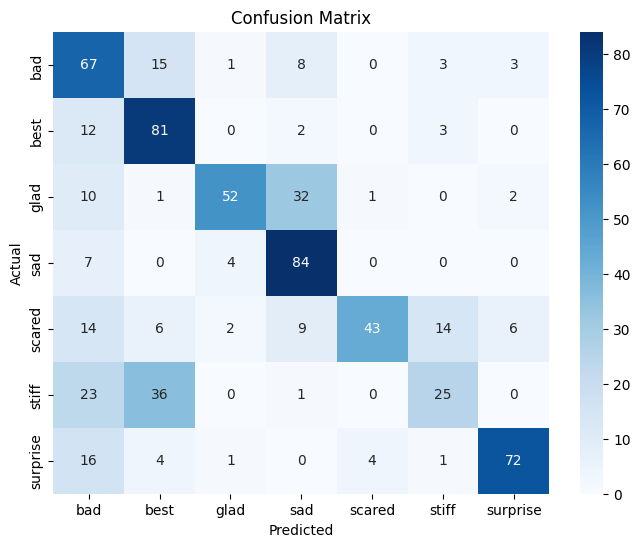

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🚀 Load trained model
signformer.eval()

# 🚀 Define label mapping (if not already defined)
class_folders = ["bad", "best", "glad", "sad", "scared", "stiff", "surprise"]  # Update with your actual class names
label_mapping = {idx: class_name for idx, class_name in enumerate(class_folders)}  # Mapping index → class name

# 🚀 Load test dataset
test_dataset = SignLanguageDataset(FEATURES_PATH, LABELS_PATH)  # Use a separate test set if available
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# 🎯 Evaluate model
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = signformer(inputs.unsqueeze(1))
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# ✅ Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {accuracy:.4f}")

# 🎭 Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# ✅ Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# 🚀 Load Multilingual BERT (mBERT) model
bert_model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=len(label_mapping)).to(device)

# 🎯 Urdu translations for gesture classes
urdu_labels = {
    "bad": "برا",
    "best": "بہترین",
    "glad": "خوش",
    "sad": "اداس",
    "scared": "ڈرا ہوا",
    "stiff": "سخت",
    "surprise": "حیران"
}

# 🔄 Function to translate class label
def translate_to_urdu(pred_label):
    if pred_label in urdu_labels:
        return urdu_labels[pred_label]
    return "نامعلوم"

# ✅ Test Urdu translation
predicted_label = "glad"
urdu_translation = translate_to_urdu(predicted_label)
print(f"✅ Predicted: {predicted_label} -> Urdu: {urdu_translation}")


/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Predicted: glad -> Urdu: خوش


In [ ]:
print(label_mapping)  # Debug: Check if label_mapping contains all indices


{'bad': 0, 'best': 1, 'glad': 2, 'sad': 3, 'scared': 4, 'stiff': 5, 'surprise': 6}


In [ ]:
import os
import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import AutoImageProcessor, SwinModel

# 🚀 Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📂 Paths
DATASET_PATH = "/content/drive/MyDrive/PkSLMNM"
swin_model_name = "microsoft/swin-tiny-patch4-window7-224"
test_video_path = os.path.join(DATASET_PATH, "best", "s0002.mp4")  # Ensure correct path

# 🎥 Extract Features from Video with Data Augmentation
def extract_frames(video_path, num_frames=16, augment=True):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print("❌ No frames found in the video.")
        return None

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    # 🌀 Data Augmentation Transformations
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of frames
        transforms.RandomRotation(degrees=15),   # Rotate frames slightly
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness & contrast
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random zoom-in
    ])

    # 🔹 Standard Transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_indices:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB
            frame = Image.fromarray(frame)  # Convert to PIL Image

            # Apply data augmentation only if enabled
            if augment:
                frame = augmentation(frame)

            frame = transform(frame)  # Apply standard preprocessing
            frames.append(frame)

    cap.release()

    if len(frames) == 0:
        print("❌ No frames selected.")
        return None

    return torch.stack(frames)

# 🚀 Load Models
processor = AutoImageProcessor.from_pretrained(swin_model_name)
swin_model = SwinModel.from_pretrained(swin_model_name).to(device)
swin_model.eval()

# Load SignFormer Model (Make sure it's already loaded somewhere)
signformer.eval()

# Label Mapping
label_mapping = {'bad': 0, 'best': 1, 'glad': 2, 'sad': 3, 'scared': 4, 'stiff': 5, 'surprise': 6}
label_mapping = {v: k for k, v in label_mapping.items()}  # Reverse mapping

# 🎥 Extract Features from the Test Video with Augmentation
frames_tensor = extract_frames(test_video_path, augment=True)  # ✅ Augmentation Applied Here
if frames_tensor is None:
    exit()

with torch.no_grad():
    features = swin_model(frames_tensor.to(device)).last_hidden_state.mean(dim=1).cpu().numpy()

# ✅ Ensure Correct Input Shape for SignFormer
video_feature = np.mean(features, axis=0)
input_tensor = torch.tensor(video_feature, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 768)

# 🚀 Reshape for SignFormer (Modify if needed)
input_tensor = input_tensor.unsqueeze(1)  # Change if SignFormer expects (batch, seq_len, feature_dim)

# 🚀 Predict Class
with torch.no_grad():
    output = signformer(input_tensor)
    predicted_class_idx = torch.argmax(output, dim=1).item()

# 🔥 Get Class Label
predicted_label = label_mapping.get(predicted_class_idx, "Unknown Sign")

# ✅ English Sentence for Translation
sentence = f"The person is using sign language for {predicted_label}"

# 🌍 Load Urdu Translator Model
translator_model = "Helsinki-NLP/opus-mt-en-ur"
tokenizer = AutoTokenizer.from_pretrained(translator_model)
translation_model = AutoModelForSeq2SeqLM.from_pretrained(translator_model).to(device)

# 🚀 Translate to Urdu
inputs = tokenizer(sentence, return_tensors="pt").to(device)
translated_ids = translation_model.generate(**inputs)
urdu_translation = tokenizer.decode(translated_ids[0], skip_special_tokens=True)

# ✅ Display Results
print(f"✅ Predicted Gesture: {predicted_label}")
print(f"✅ English: {sentence}")
print(f"✅ Urdu Translation: {urdu_translation}")


✅ Predicted Gesture: best
✅ English: The person is using sign language for best
✅ Urdu Translation: آدمی کی زبان کو اچھی طرح سے استعمال کر رہا ہے


In [ ]:
model_save_path = "/content/drive/MyDrive/PkSLMNM/signformer.pth"  # Change path as needed
torch.save(signformer.state_dict(), model_save_path)
print(f"✅ Model saved at {model_save_path}")


✅ Model saved at /content/drive/MyDrive/PkSLMNM/signformer.pth
